# Evaluating Player Similarity Predictions

In our previous experiments, our results are not reliable due to our training data crossing with test data!

To simulate what would happen realistically, we need to split train and test data before we start our similarity pairing & prediction.


In [1]:
import warnings
from pathlib import Path

from opal.score.dataset import Dataset
from opal.score.preprocessing_dynamic import PreprocessingDynamic
from opal.score.similarity import SimilarityModel

if True:
    # PyCharm linting keeps wrecking this import, so it's in a True cond
    pass

warnings.filterwarnings('ignore')

data_path = Path("../../data/osu/scores/")

df = PreprocessingDynamic(
    Dataset(data_path, "top1k").joined_filtered_df,
    unpopular_maps_thres=0.2,
    unpopular_plays_thres=0.2,
    sr_min_thres=2.5,
    acc_filter=(0.85, 1),
    score_filter=None
).filter(calc_acc=True)

by_score_year 887452 -> 541019
by_sr 541019 -> 481548
by_unpopular_maps 481548 -> 279765
by_unpopular_plays 279765 -> 75055
by_acc_filter 75055 -> 74961
by_remove_mod 74961 -> 71327
Users Left: 291 | Beatmaps Left: 718


To perform evaluation, we perform a 5-fold validation, 20% test, 80% train.

In [3]:
from sklearn.model_selection import KFold
from tqdm import tqdm

kf = KFold(shuffle=True, random_state=0)
actuals_l = []
preds_l = []
for train_ix, test_ix in kf.split(df):
    train_df, test_df = df.iloc[train_ix], df.iloc[test_ix],
    sim = SimilarityModel().fit(train_df)

    actuals, preds = [], []
    for ix, test_score in tqdm(test_df.iterrows(),
                               total=len(test_df),
                               desc="Predicting Scores"):
        try:
            pred = sim.predict(
                test_score['user_id'],
                test_score['year'],
                test_score['map_id']
            )
        except ZeroDivisionError or Exception:
            continue
        actuals.append(test_score['accuracy'])
        preds.append(pred)

    actuals_l.append(actuals)
    preds_l.append(preds)

import pandas as pd

dfs = []
for e, (actuals, preds) in enumerate(zip(actuals_l, preds_l)):
    df = pd.DataFrame([actuals, preds]).T
    df.columns = ['actual', 'pred']
    df['k'] = e
    dfs.append(df)
df = pd.concat(dfs).reset_index(drop=True)

Predicting Scores: 100%|██████████| 14265/14265 [03:48<00:00, 62.39it/s]


Took quite a while to evaluate, however, we finally simulated and evaluated a reliable result.

Let's take a look at it

Before we do that, let's save the results in case we lose it

In [8]:
import pickle

with open("results.pkl", "wb+") as f:
    pickle.dump(df, f)
with open("results.pkl", "rb+") as f:
    df = pickle.load(f)

## Metrics

We find the MSE & R^2

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

print(f"MSE: {mean_squared_error(df['actual'], df['pred'], squared=False):.3%}")
print(f"R^2: {r2_score(df['actual'], df['pred'])}")

MSE: 1.663%
R^2: 0.5902836196906478


## Error across Accuracies

They are decent, however, it's known that accuracies on the upper end are harder to achieve.
How does the error differ?

Let's analyze this with a scatter plot

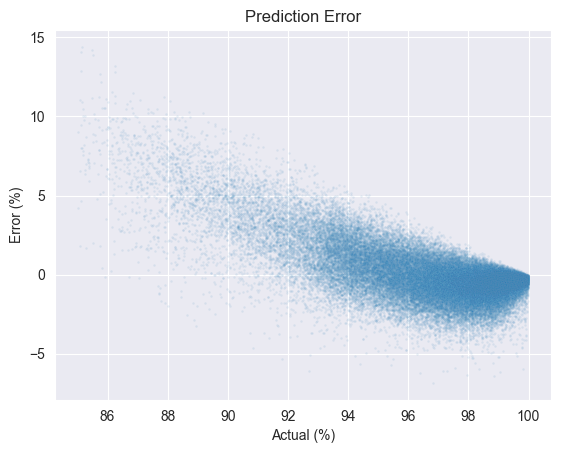

In [20]:
sns.scatterplot(
    x=(df['actual']) * 100,
    y=(df['pred'] - df['actual']) * 100,
    s=3,
    alpha=0.1
)
_ = plt.xlabel("Actual (%)")
_ = plt.ylabel("Error (%)")
_ = plt.title("Prediction Error")

It's rather difficult to see how the error differs, here, let's try with binning.

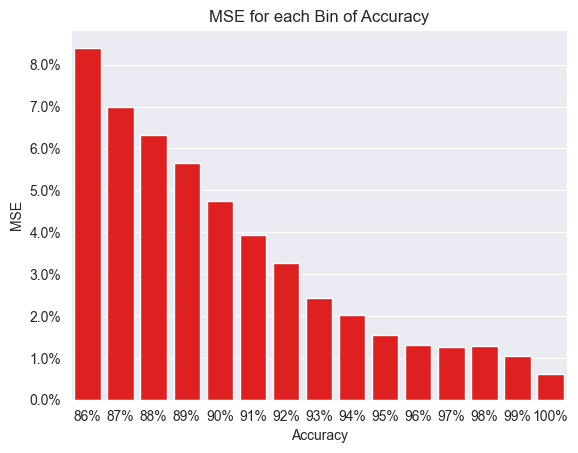

In [61]:
df['error'] = df['pred'] - df['actual']
df['error2'] = df['error'] ** 2
dfg = df.groupby(pd.cut(df['actual'], bins=25)).mean()[['error2']] ** 0.5
sns.barplot(x=[f"{i.right:.0%}" for i in dfg.index],
            y=dfg['error2'],
            color='red', ci=None)
from matplotlib.ticker import FuncFormatter

_ = plt.xlabel("Accuracy")
_ = plt.ylabel("MSE")
_ = plt.title("MSE for each Bin of Accuracy")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

Interestingly, MSE is very large for lower accuracies, possibly rendering them useless.
However, is very low for higher accuracies.

The MSE we observed may be heavily influenced by the fact that we had many scores in the higher range.

## Summary

By using a small subset of our data, we can see our MSE is spread out.

Finally, we need to upscale our workflow to enable us to use more data:
- We have been using the Top 1K Player set
- We prevented some scores by filtering them
- We used the April 2022 set, which may be outdated.